# Análisis Encuesta Origen-Destino -  Limpieza de Datos & Cálculo de Indicadores

## Uruguay - Montevideo - 2016

#### Elaborado por Paula Vásquez-Henríquez, Ariel López, Genaro Cuadros, Exequiel Gaete, Alba Vásquez y Juan Correa

In [ ]:
!pip3 uninstall matplotlib -y

Found existing installation: matplotlib 3.2.2
Uninstalling matplotlib-3.2.2:
  Successfully uninstalled matplotlib-3.2.2


In [ ]:
!pip install -q condacolab
import condacolab
condacolab.install()

⏬ Downloading https://github.com/jaimergp/miniforge/releases/latest/download/Mambaforge-colab-Linux-x86_64.sh...
📦 Installing...
📌 Adjusting configuration...
🩹 Patching environment...
⏲ Done in 0:00:33
🔁 Restarting kernel...


In [ ]:
!git clone https://github.com/zorzalerrante/aves.git aves_git

Cloning into 'aves_git'...
remote: Enumerating objects: 832, done.
remote: Counting objects: 100% (463/463), done.
remote: Compressing objects: 100% (224/224), done.
remote: Total 832 (delta 200), reused 435 (delta 183), pack-reused 369
Receiving objects: 100% (832/832), 165.53 MiB | 27.36 MiB/s, done.
Resolving deltas: 100% (323/323), done.
Checking out files: 100% (280/280), done.


In [ ]:
!mamba env update --name base --file aves_git/environment-colab.yml

conda-forge/linux-64     [] (00m:00s) 
conda-forge/linux-64     [] (00m:00s) 65 KB / ?? (204.66 KB/s)
conda-forge/linux-64     [] (00m:00s) 65 KB / ?? (204.66 KB/s)
pkgs/main/linux-64       [] (00m:00s) 
conda-forge/linux-64     [] (00m:00s) 65 KB / ?? (204.66 KB/s)
pkgs/main/linux-64       [] (00m:00s) 45 KB / ?? (142.13 KB/s)
conda-forge/linux-64     [] (00m:00s) 65 KB / ?? (204.66 KB/s)
pkgs/main/linux-64       [] (00m:00s) 45 KB / ?? (142.13 KB/s)
pkgs/main/noarch         [] (00m:00s) 
conda-forge/linux-64     [] (00m:00s) 65 KB / ?? (204.66 KB/s)
pkgs/main/linux-64       [] (00m:00s) 45 KB / ?? (142.13 KB/s)
pkgs/main/noarch         [] (00m:00s) 399  B / ?? (1.22 KB/s)
conda-forge/linux-64     [] (00m:00s) 65 KB / ?? (204.66 KB/s)
pkgs/main/linux-64       [] (00m:00s) 45 KB / ?? (142.13 KB/s)
pkgs/main/noarch         [] (00m:00s) 399  B / ?? (1.22 KB/s)
pkgs/r/linux-64          [] (00m:00s) 
conda-forge/linux-64     [] (00m:00s) 65 KB / ?? (204.66 KB/s)
pkgs/main/linux-64       []

In [ ]:
!pip3 install geopandas
!pip3 install pandasql
!pip3 install seaborn

     |████████████████████████████████| 1.6 MB 7.7 MB/s 
     |████████████████████████████████| 150 kB 56.6 MB/s 
  Created wheel for pandasql: filename=pandasql-0.7.3-py3-none-any.whl size=26818 sha256=1b83f5108add3cb430c04bdf91f371f67366e58d6467731ce075906d8923a2f8
  Stored in directory: /root/.cache/pip/wheels/5c/4b/ec/41f4e116c8053c3654e2c2a47c62b4fca34cc67ef7b55deb7f
Successfully built pandasql


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import geopandas as gpd
import warnings
#import haversine as hs
import shapely
from sklearn.preprocessing import normalize
import datetime

In [ ]:
def decode_column(df, fname, col_name, index_col='id', value_col=None, sep=';', encoding='utf-8'):
    '''
    param :df: DataFrame del que leeremos una columna.
    param :fname: nombre del archivo que contiene los valores a decodificar.
    param :col_name: nombre de la columna que queremos decodificar.
    param :index_col: nombre de la columna en el archivo @fname que tiene los índices que codifican @col_name
    param :value_col: nombre de la columna en el archivo @fname que tiene los valores decodificados
    param :sep: carácter que separa los valores en @fname. 
    param :encoding: identificación del _character set_ que utiliza el archivo. Usualmente es utf-8, si no funciona,
                     se puede probar con iso-8859-1.
    '''
    if value_col is None:
        value_col = 'value'
        
    values_df = pd.read_csv(fname, sep=sep, index_col=index_col, names=[index_col, value_col], header=0,
                            dtype={index_col: np.float64}, encoding=encoding)
    
    src_df = df.loc[:,(col_name,)]
    
    return src_df.join(values_df, on=col_name)[value_col]

In [ ]:
def convert_datatype(df, lista_columnas):
    for column in lista_columnas:
        df[column] = df[column].str.replace(",", ".").astype(float)
    return df

In [ ]:
def imputar_coordenadas_centroide_zat(df, latitud, longitud, zat, zat_shp):
    mask = df[latitud].isnull() | df[longitud].isnull()
    ids_latitud_vacia = df[mask].index
    working_df = pd.merge(df, city_shp[[zat_shp, 'x_coord', 'y_coord']], left_on=zat, right_on=zat_shp, how='left')
    df.loc[ids_latitud_vacia, latitud] = working_df.loc[ids_latitud_vacia, 'y_coord']
    df.loc[ids_latitud_vacia, longitud] = working_df.loc[ids_latitud_vacia, 'x_coord']
    return df

In [ ]:
def mapear_binarias(row, column):
    if row[column] == 'N':
        return 'No'
    elif row[column] == 'S':
        return 'Si'
    else:
        return 'Sin dato'

In [ ]:
def mapear_vacios(row, column):
    if pd.isna(row[column])==True:
        return 'Sin información'
    else:
        return row[column]

In [ ]:
def age_cohorts(row, age_column):
    if row[age_column] < 18:
        return '<18'
    elif row[age_column] <=29 and row[age_column] > 18:
        return '18-29'
    elif row[age_column] <=60 and row[age_column] > 29:
        return '30-60'
    elif row[age_column] > 60 and row[age_column] < 100:
        return '>60'
    else:
        return 'No declarado'

In [ ]:
def normalize_rows(df):
    return df.pipe(lambda x: pd.DataFrame(normalize(df, axis=1, norm='l1'), columns=df.columns, index=df.index))

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Caracterización de los datos

Los datos utilizados en este cuaderno corresponden a los resultados de la Encuesta Origen-Destino de Montevideo, Uruguay del 2016. 
A partir de estos datos se calcularan indicadores en tres niveles: de Cantidad de Viajes, de Tiempo de Viajes, y de Distancia de Viajes.

### Importando datos

En esta sección, importamos todos los datos necesarios para el cálculo de indicadores. 
Para el caso de Bogotá 2015, los archivos son de Excel y es necesario hacer una transformación de los datos numéricos.

Cabe destacar que para esta EOD tenemos data a nivel de:
- Viajes
- Etapas
- Personas
- Hogares


In [ ]:
data_path = '/content/drive/MyDrive/Carpeta compartida (clon Teams)/Ciudades/Montevideo/EOD2016'
#data_path = '/Users/pauvasquezh/Dropbox/Proyectos/eod_analysis/Carpeta compartida (clon Teams)/Montevideo/EOD2016'

In [ ]:
# Matriz de viajes
data_viajes = pd.read_csv(data_path + '/Base Viajes.csv', sep=';', encoding='utf-8')
data_viajes[["codsegorigen", "codsegproposito"]] = data_viajes[["codsegorigen", "codsegproposito"]].fillna(value=0)
data_viajes = convert_datatype(data_viajes, ["wcal0", "VF5"])

In [ ]:
# Matriz de personas
data_personas = pd.read_csv(data_path + '/Base Personas.csv', sep=';', encoding='utf-8')
data_personas.head(2)
data_personas = convert_datatype(data_personas, ['wcal0'])

In [ ]:
# Matriz de hogares
data_encuestas = pd.read_csv(data_path + '/Base Hogar Habitos.csv', sep=';', encoding='utf-8')
data_encuestas.head(2)
data_encuestas = convert_datatype(data_encuestas, ['wcal0'])

In [ ]:
# Shapefile de la ciudad
city_shp = gpd.read_file(data_path + "/Mapas Vectoriales año 2011/ine_seg_11.shp")

In [ ]:
city_shp = city_shp.set_crs('epsg:32721').to_crs('epsg:32721')

In [ ]:
city_shp['x_coord'] = city_shp.centroid.x
city_shp['y_coord'] = city_shp.centroid.y

In [ ]:
city_shp.crs

<Projected CRS: EPSG:32721>
Name: WGS 84 / UTM zone 21S
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Between 60°W and 54°W, southern hemisphere between 80°S and equator, onshore and offshore. Argentina. Bolivia. Brazil. Falkland Islands (Malvinas). Paraguay. Uruguay.
- bounds: (-60.0, -80.0, -54.0, 0.0)
Coordinate Operation:
- name: UTM zone 21S
- method: Transverse Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

### Preparación de los datos

#### Viajes

En esta etapa nos enfocaremos en preparar los datos con respecto a viajes.
En particular, nos enfocamos en limpiar y estandarizar los datos para las columnas que son relevantes para el cálculo de indicadores.

In [ ]:
data_viajes.proposito = decode_column(data_viajes, data_path + '/data_dictionaries/propositos.csv', 'proposito')
data_viajes.proposito.unique()

array(['Trabajo', 'Dejar/recoger niños', 'Regreso al hogar/hogar',
       'Estudios', 'Compras (hogar)', 'Asistencia médica', 'Otro',
       'Entretenimiento / ocio', 'Visitar a alguien', 'Ir a comer',
       'Tramites personal', 'Tramites trabajo', 'Acompañar a alguien',
       'Compras', 'Dejar/recoger a alguien', 'Culto', 'Sin_dato'],
      dtype=object)

In [ ]:
data_viajes.modoprincipal = decode_column(data_viajes, data_path + '/data_dictionaries/modo.csv', 'modoprincipal')
data_viajes.modoprincipal.unique()

array(['Bus', 'A pie', 'Auto conductor', 'A pie hasta 10 cuadras',
       'Auto pasajero', 'Bicicleta', 'Bus escolar', 'Moto pasajero',
       'Moto conductor', 'Otros, sin especificar', 'Taxi',
       'Bus de la empresa', 'Remise', 'Otro Uber', 'Ferrocarril'],
      dtype=object)

In [ ]:
publico_viaje = ['Bus','Remise','Ferrocarril']
privado_viaje = [ 'A pie', 'Auto conductor', 'A pie hasta 10 cuadras',
       'Auto pasajero', 'Bicicleta', 'Bus escolar', 'Moto pasajero',
       'Moto conductor', 'Taxi',
       'Bus de la empresa', 'Otro Uber']
peaton_viaje = ['A pie', 'Bicicleta', 'A pie hasta 10 cuadras']
motorizado_viaje = ['Bus','Remise','Auto conductor','Auto pasajero', 'Bus escolar', 'Moto pasajero',
       'Moto conductor' 'Taxi',
       'Bus de la empresa', 'Otro Uber']

In [ ]:
selected_columns = ['nform', 'nnper', 'nvj', 'IDPERV', 'origen', 'proposito', 'VF5', 'VF6',
       'tiempoviaje', 'modoprincipal','codsegorigen', 'codsegproposito',
       'wcal0']
viajes_df = data_viajes[selected_columns]

In [ ]:
viajes_df['LATITUD_ORIGEN'] = None
viajes_df['LONGITUD_ORIGEN'] = None
viajes_df['LATITUD_DESTINO'] = None
viajes_df['LONGITUD_DESTINO'] = None

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

In [ ]:
viajes_df = imputar_coordenadas_centroide_zat(viajes_df, 'LATITUD_ORIGEN', 'LONGITUD_ORIGEN', 'codsegorigen', 'CODSEG')
viajes_df = imputar_coordenadas_centroide_zat(viajes_df, 'LATITUD_DESTINO', 'LONGITUD_DESTINO','codsegproposito', 'CODSEG')

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


In [ ]:
viajes_df.shape

(12537, 17)

In [ ]:
print('Contando valores nulos por atributo')
for column in viajes_df.columns:
    print('{}: {}'.format(column, viajes_df[column].isna().sum()))

Contando valores nulos por atributo
nform: 0
nnper: 0
nvj: 0
IDPERV: 0
origen: 0
proposito: 0
VF5: 3
VF6: 3
tiempoviaje: 67
modoprincipal: 0
codsegorigen: 0
codsegproposito: 0
wcal0: 0
LATITUD_ORIGEN: 70
LONGITUD_ORIGEN: 70
LATITUD_DESTINO: 57
LONGITUD_DESTINO: 57


In [ ]:
mask = viajes_df.LATITUD_ORIGEN.isna() | viajes_df.LATITUD_DESTINO.isna()
viajes_df = viajes_df[~mask]

In [ ]:
# Limpiando datos de variables binarias

In [ ]:
def pico_habil(row):
    if row['VF5'] >= 7.0 and row['VF5'] <= 9.0:
        return'Si'
    else:
        return 'No'
    
viajes_df['PICO_HABIL'] = viajes_df.apply(lambda row: pico_habil(row), axis=1)

In [ ]:
viajes_df['Intra_Inter'] = viajes_df.apply(lambda row: 'Intra' if row['codsegorigen'] == row['codsegproposito'] else 'Inter', axis=1)

In [ ]:
# Clasificando los viajes como públicos o privados según medio
def publico_privado(row, column, publico, privado):
    if row[column] in (publico):
        return 'Público'
    elif row[column] in (privado):
        return 'Privado'
    else:
        return 'Otro'
    
viajes_df['publico_privado'] = viajes_df.apply(lambda row: publico_privado(row, 'modoprincipal', publico_viaje, privado_viaje), axis=1)

In [ ]:
def motorizado(row, column, no_motorizado, motorizado):
    if row[column] in (motorizado):
        return 'Motorizado'
    elif row[column] in (no_motorizado):
        return 'No Motorizado'
    else:
        return 'Otro'
    
viajes_df['motorizado'] = viajes_df.apply(lambda row: motorizado(row, 'modoprincipal', peaton_viaje,motorizado_viaje), axis=1)

In [ ]:
viajes_df['duracion'] = (viajes_df['tiempoviaje'])

In [ ]:
def manhattan_distance(a, b):
    return np.abs(a - b).sum()

In [ ]:
viajes_df['distancia_manhattan'] = viajes_df.apply(lambda row: manhattan_distance(np.array([row['LATITUD_ORIGEN'], row['LONGITUD_ORIGEN']]), np.array([row['LATITUD_DESTINO'], row['LONGITUD_DESTINO']])), axis=1)

In [ ]:
print('Contando valores nulos por atributo')
for column in viajes_df.columns:
    print('{}: {}'.format(column, viajes_df[column].isna().sum()))

Contando valores nulos por atributo
nform: 0
nnper: 0
nvj: 0
IDPERV: 0
origen: 0
proposito: 0
VF5: 0
VF6: 2
tiempoviaje: 55
modoprincipal: 0
codsegorigen: 0
codsegproposito: 0
wcal0: 0
LATITUD_ORIGEN: 0
LONGITUD_ORIGEN: 0
LATITUD_DESTINO: 0
LONGITUD_DESTINO: 0
PICO_HABIL: 0
Intra_Inter: 0
publico_privado: 0
motorizado: 0
duracion: 55
distancia_manhattan: 0


In [ ]:
viajes_df['idviaje'] = viajes_df['nform'].astype('str')+viajes_df['nnper'].astype('str') + viajes_df['nvj'].astype('str')

In [ ]:
viajes_df.shape

(12414, 24)

In [ ]:
viajes_df.to_csv(data_path + '/viajes_montevideo_2016.csv', index=False)

#### Personas y Hogares

En esta etapa nos enfocaremos en preparar los datos con respecto a personas.
En particular, nos enfocamos en limpiar y estandarizar los datos para las columnas que son relevantes para el cálculo de indicadores.


In [ ]:
data_personas.columns

Index(['nform', 'nnper', 'IDPER', 'SEXO', 'EDAD', 'PARENTESCO', 'E3', 'E4',
       'E4A', 'E5', 'E6', 'E7', 'E7OB', 'E8', 'E9', 'E10', 'E11', 'E12', 'E14',
       'E15', 'E16', 'E17', 'E19', 'E20', 'E200B', 'Form_Op_Hab',
       'codsegtrabprinc', 'codsegpresentrab', 'codsegcomenzodia', 'INSE',
       'INSE_RecF', 'EstratoGeografico', 'wcal0'],
      dtype='object')

In [ ]:
selected_columns = ['nform', 'nnper', 'IDPER', 'SEXO','INSE',
       'INSE_RecF', 'wcal0','E10', 'EDAD']
personas_df = data_personas[selected_columns]

In [ ]:
personas_df.INSE_RecF = personas_df.INSE_RecF.replace(' ', 'Sin dato')

/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:5170: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [ ]:
personas_df.columns

Index(['nform', 'nnper', 'IDPER', 'SEXO', 'INSE', 'INSE_RecF', 'wcal0', 'E10',
       'EDAD'],
      dtype='object')

In [ ]:
personas_df['SEXO'] = decode_column(personas_df, data_path + '/data_dictionaries/gender.csv', 'SEXO')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
segmentos = gpd.read_file(data_path + "/Mapas Vectoriales año 2011/ine_seg_11.shp")

In [ ]:
selected_columns = ['nform', 'codseghogar']
encuestas_df = data_encuestas[selected_columns]

In [ ]:
encuestas_df = pd.merge(encuestas_df, segmentos[['CODSEG', 'CODLOC', 'NOMBLOC']], left_on='codseghogar', right_on='CODSEG', how='left')

In [ ]:
personas_df = pd.merge(personas_df, encuestas_df, on='nform', how='left')

In [ ]:
viajes_personas = pd.merge(viajes_df, personas_df, on=['nform', 'nnper'], how='left')

In [ ]:
print('Contando valores nulos por atributo')
for column in viajes_personas.columns:
    print('{}: {}'.format(column, viajes_personas[column].isna().sum()))

Contando valores nulos por atributo
nform: 0
nnper: 0
nvj: 0
IDPERV: 0
origen: 0
proposito: 0
VF5: 0
VF6: 2
tiempoviaje: 55
modoprincipal: 0
codsegorigen: 0
codsegproposito: 0
wcal0_x: 0
LATITUD_ORIGEN: 0
LONGITUD_ORIGEN: 0
LATITUD_DESTINO: 0
LONGITUD_DESTINO: 0
PICO_HABIL: 0
Intra_Inter: 0
publico_privado: 0
motorizado: 0
duracion: 55
distancia_manhattan: 0
idviaje: 0
IDPER: 0
SEXO: 0
INSE: 0
INSE_RecF: 0
wcal0_y: 0
E10: 0
EDAD: 0
codseghogar: 0
CODSEG: 0
CODLOC: 0
NOMBLOC: 0


In [ ]:
viajes_personas.to_csv(data_path + '/viajes_personas_montevideo_2016.csv', index=False)

### Descripción de los datos

¿Dónde viven los encuestados?

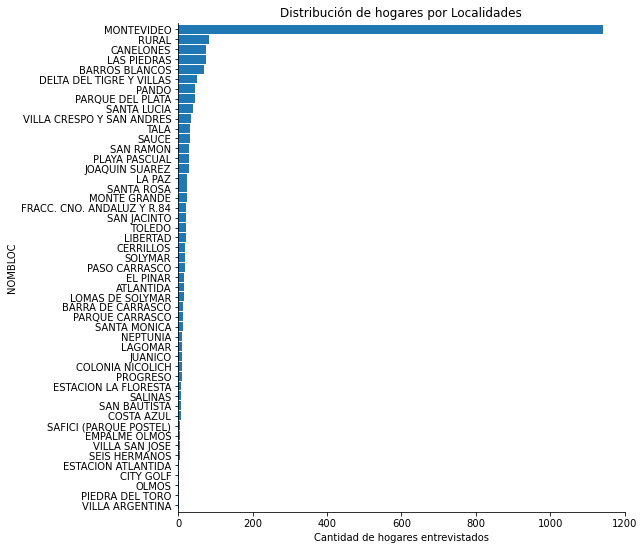

In [ ]:
hogares_por_barrio = encuestas_df.groupby("NOMBLOC").size().sort_values()

ax = hogares_por_barrio[-49:].plot(kind="barh", width=0.9, figsize=(8, 9))
ax.set_xlabel("Cantidad de hogares entrevistados")
ax.set_title("Distribución de hogares por Localidades")
sns.despine()

¿Quienes son las personas encuestadas?

In [ ]:
personas_df = personas_df[personas_df.EDAD!=' ']
personas_df.EDAD = personas_df.EDAD.astype('float64')

In [ ]:
personas_df['EDAD'].describe()

count    5937.000000
mean       38.773623
std        23.457256
min         0.000000
25%        18.000000
50%        38.000000
75%        57.000000
max        99.000000
Name: EDAD, dtype: float64

In [ ]:
personas_df['age_cohort'] = personas_df.apply(lambda row: age_cohorts(row, 'EDAD'), axis=1)

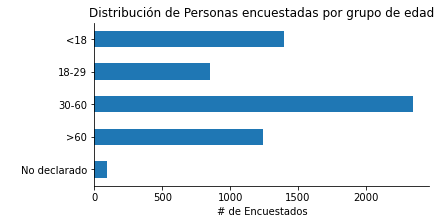

In [ ]:
order = ['<18', '18-29', '30-60','>60','No declarado']
ax = (personas_df.groupby(['age_cohort']).size().loc[reversed(order)]
 .plot(kind='barh', figsize=(6,3)))
ax.set_xlabel("# de Encuestados")
ax.set_ylabel(" ")
ax.set_title("Distribución de Personas encuestadas por grupo de edad")
sns.despine()

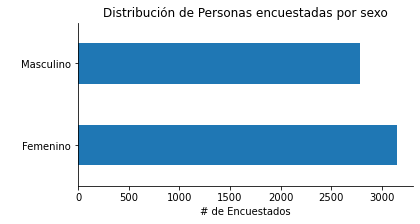

In [ ]:
ax = (personas_df.groupby(['SEXO']).size()
 .plot(kind='barh', figsize=(6,3)))
ax.set_xlabel("# de Encuestados")
ax.set_ylabel(" ")
ax.set_title("Distribución de Personas encuestadas por sexo")
sns.despine()

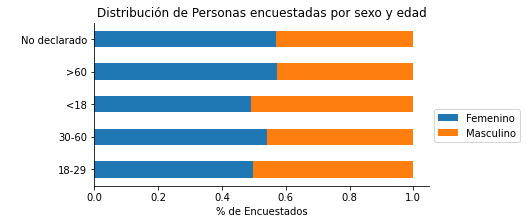

In [ ]:
ax = (personas_df.groupby(['age_cohort', 'SEXO']).size().unstack()
 .pipe(normalize_rows)
 .plot(kind='barh', stacked=True, figsize=(6, 3)))
ax.set_xlabel("% de Encuestados")
ax.set_ylabel(" ")
ax.set_title("Distribución de Personas encuestadas por sexo y edad")
sns.despine()

plt.legend(loc=0, bbox_to_anchor=(1.0, 0.5))

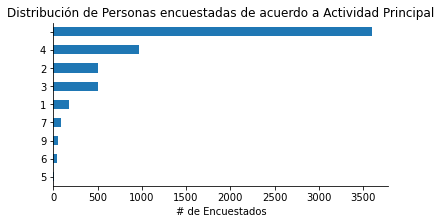

In [ ]:
ax = (personas_df.groupby(['E10']).size().sort_values()
 .plot(kind='barh', figsize=(6,3)))
ax.set_xlabel("# de Encuestados")
ax.set_ylabel(" ")
ax.set_title("Distribución de Personas encuestadas de acuerdo a Actividad Principal")
sns.despine()

### Parte I: Indicadores de Cantidad de Viajes

En esta primera parte, responderemos algunas preguntas respecto a indicadores de cantidades de viajes realizados, en días hábiles y no hábiles de viaje. Para esto, buscaremos responder las siguientes preguntas:

1. ¿Cuál es la tasa promedio de viajes diarios en transporte público por clasificador económico?
2. ¿Cuál es la tasa promedio de viajes diarios en transporte privado por clasificador económico?
3. ¿Cuál es la razón entre los viajes en transporte público y privado por clasificador socioeconómico?
4. ¿Cuál es la distribución/partición modal de los viajes por clasificador socioeconómico?

En esta sección, se detallarán los resultados para indicadores a nivel de viajes, y por clasificador socioeconómico.

In [ ]:
print('Cantidad de viajes mapeados: totales encuesta , total expandido')
viajes_habiles = viajes_personas
print('Total Viajes Habiles: {}'.format(viajes_habiles.shape[0]), viajes_habiles['wcal0_x'].sum())

Cantidad de viajes mapeados: totales encuesta , total expandido
Total Viajes Habiles: 12414 4155598.51447121


Separamos los viajes habiles y no habiles de acuerdo a si son privados o publicos

In [ ]:
viajes_publico_habiles = viajes_habiles[viajes_habiles.modoprincipal.isin(publico_viaje)]

viajes_privado_habiles = viajes_habiles[viajes_habiles.modoprincipal.isin(privado_viaje)]

In [ ]:
viajes_publico_habiles.columns

Index(['nform', 'nnper', 'nvj', 'IDPERV', 'origen', 'proposito', 'VF5', 'VF6',
       'tiempoviaje', 'modoprincipal', 'codsegorigen', 'codsegproposito',
       'wcal0_x', 'LATITUD_ORIGEN', 'LONGITUD_ORIGEN', 'LATITUD_DESTINO',
       'LONGITUD_DESTINO', 'PICO_HABIL', 'Intra_Inter', 'publico_privado',
       'motorizado', 'duracion', 'distancia_manhattan', 'idviaje', 'IDPER',
       'SEXO', 'INSE', 'INSE_RecF', 'wcal0_y', 'E10', 'EDAD', 'codseghogar',
       'CODSEG', 'CODLOC', 'NOMBLOC'],
      dtype='object')

In [ ]:
def weighted_mean(df, value_column, weighs_column):
    weighted_sum = (df[value_column] * df[weighs_column]).sum()
    return weighted_sum / df[weighs_column].sum()

In [ ]:
def weighted_median(df, val, weight):
    df_sorted = df.sort_values(val)
    cumsum = df_sorted[weight].cumsum()
    cutoff = df_sorted[weight].sum() / 2.
    return df_sorted[cumsum >= cutoff][val].iloc[0]

#### **¿Cuál es la tasa promedio de viajes diarios en transporte público por clasificador económico?**

Los siguientes gráficos muestran los viajes per cápita en trasporte público durante días hábiles, por clasificador socioeconómico.

In [ ]:
from pandasql import sqldf
def calculate_n_viajes_per_capita(df, df_str, agg_columns_str, agg_columns_lst, id_person, person_weight, trip_weight=None):
    q = "SELECT DISTINCT {}, {}, {} FROM {}".format(id_person, agg_columns_str, person_weight, df_str)
    persons = sqldf(q, globals())
    n_personas = persons.groupby(agg_columns_lst).sum()[[person_weight]].reset_index()
    n_personas[agg_columns_lst[0]] = n_personas[agg_columns_lst[0]].astype(str)
    n_viajes = df.groupby(agg_columns_lst).sum()[[trip_weight]].reset_index()
    n_viajes[agg_columns_lst[0]] = n_viajes[agg_columns_lst[0]].astype(str)
    merged = pd.merge(n_personas, n_viajes, on=agg_columns_lst, how='left')
    merged['viajes_per_capita'] = merged[trip_weight] / merged[person_weight]
    return merged

In [ ]:
print('Viajes per cápita en transporte público')
df = calculate_n_viajes_per_capita(viajes_publico_habiles, "viajes_publico_habiles", "INSE_RecF", ["INSE_RecF"], 'nnper', 'wcal0_x', 'wcal0_y')

Viajes per cápita en transporte público


In [ ]:
df.INSE_RecF.unique()

array(['A+', 'A-', 'B+', 'B-', 'M', 'M+', 'M-', 'Sin dato'], dtype=object)

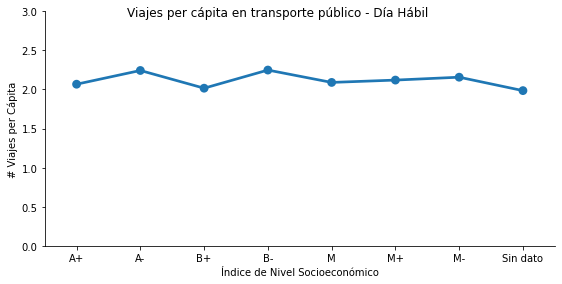

In [ ]:
#fig, ax = plt.subplots(figsize=(8,6))
g = sns.catplot(x="INSE_RecF", y="viajes_per_capita", 
                capsize=.2, height=4, aspect=2,
                kind="point", data=df)

g.fig.suptitle('Viajes per cápita en transporte público - Día Hábil')
g.set_ylabels('# Viajes per Cápita')
g.set_xlabels('Índice de Nivel Socioeconómico')
g.set(ylim=(0,3))

#fig.tight_layout()

#### **¿Cuál es la tasa promedio de viajes diarios en transporte privado por clasificador económico?**

Los siguientes gráficos representan la tasa promedio de viajes diarios en el transporte privado durante días hábiles, por clasificador socioeconómico.

In [ ]:
print('Viajes per cápita en transporte privado')
df = calculate_n_viajes_per_capita(viajes_privado_habiles, "viajes_privado_habiles", "INSE_RecF", ["INSE_RecF"], 'nnper', 'wcal0_x', 'wcal0_y')

Viajes per cápita en transporte privado


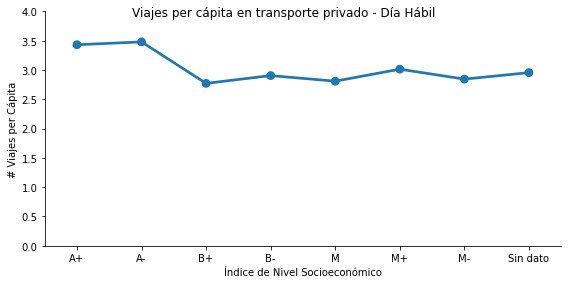

In [ ]:
g = sns.catplot(x="INSE_RecF", y="viajes_per_capita", 
                capsize=.2, height=4, aspect=2,
                kind="point", data=df)

g.fig.suptitle('Viajes per cápita en transporte privado - Día Hábil')
g.set_ylabels('# Viajes per Cápita')
g.set_xlabels('Índice de Nivel Socioeconómico')
g.set(ylim=(0,4))

#fig.tight_layout()

Durante días hábiles, los viajes realizados en transporte público tienen valores similares a través de los distintos niveles socioeconómicos. En días no hábiles, los grupos con mayor índice de nivel socioeconómico tienen mayor cantidad de viajes.

#### **¿Cuál es la razón entre los viajes en transporte público y privado por clasificador socioeconómico?**

Los gráficos a continuación muestran la razón entre los viajes en transporte público y transporte privado durante días hábiles, por clasificador socioeconómico.

In [ ]:
print('Razón entre los viajes en transporte público y privado - Día Hábil')
df = viajes_privado_habiles.groupby(["INSE_RecF"]).agg(privado_sobre_publico = ('wcal0_x', 'sum')) / viajes_publico_habiles.groupby(["INSE_RecF"]).agg(privado_sobre_publico = ('wcal0_x', 'sum'))
df = df.reset_index()

Razón entre los viajes en transporte público y privado - Día Hábil


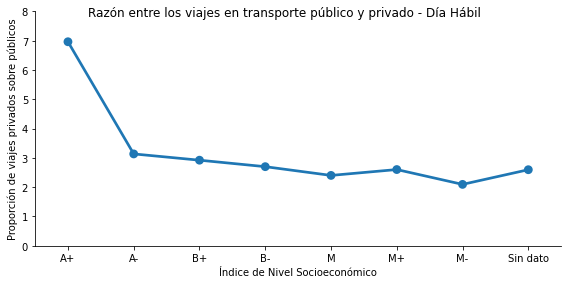

In [ ]:
g = sns.catplot(x="INSE_RecF", y="privado_sobre_publico",
                capsize=.2, height=4, aspect=2,
                kind="point", data=df)

g.fig.suptitle('Razón entre los viajes en transporte público y privado - Día Hábil')
g.set_ylabels('Proporción de viajes privados sobre públicos')
g.set_xlabels('Índice de Nivel Socioeconómico')
g.set(ylim=(0,8))

#fig.tight_layout()

La razón entre viajes privados y públicos es mayor en el grupo con mayor nivel socioeconómico, y se mantiene estable a través de los otros grupos.

#### **¿Cuál es la distribución/partición modal de los viajes por clasificador socioeconómico?**

Las siguientes tablas y gráficos representan la partición modal de los viajes realizados en días hábiles, por clasificador socioeconómico.

In [ ]:
print('Partición Modal de los Viajes')
df = viajes_habiles.groupby(["INSE_RecF", 'modoprincipal']).sum()['wcal0_x'].unstack()
#.agg(count=('MEDIO_PREDOMINANTE','count')).unstack()
df_norm = df.div(df.sum(axis=1), axis=0)

Partición Modal de los Viajes


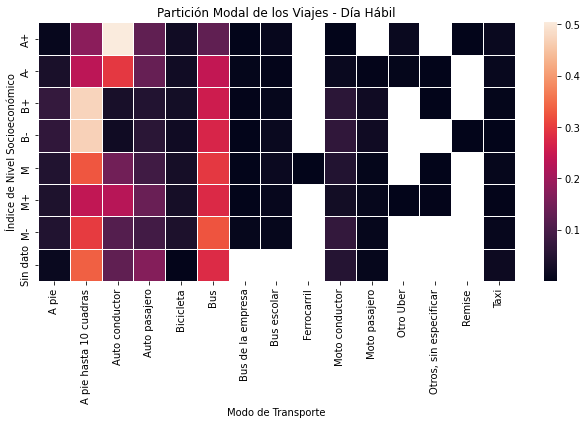

In [ ]:
fig, ax = plt.subplots(figsize=(9, 6))

ax = sns.heatmap(df_norm,linewidth=0.5)

ax.set_title("Partición Modal de los Viajes - Día Hábil")
ax.set_xlabel("Modo de Transporte")
ax.set_ylabel("Índice de Nivel Socioeconómico")

fig.tight_layout()

Los modos de transporte con mayor distribución son A pie hasta 10 cuadras, el cual es más alto en los grupos son nivel socioeconómico menor, Bus y Auto conductor, en el cual se observa una diferencia entre grupos socioeconómicos, con bajos valores para los niveles más bajos.

In [ ]:
print('Partición Modal de los Viajes por tipo de transporte')
df = viajes_habiles.groupby(["INSE_RecF", 'publico_privado']).sum()['wcal0_x'].unstack()
df_norm = df.div(df.sum(axis=1), axis=0)

Partición Modal de los Viajes por tipo de transporte


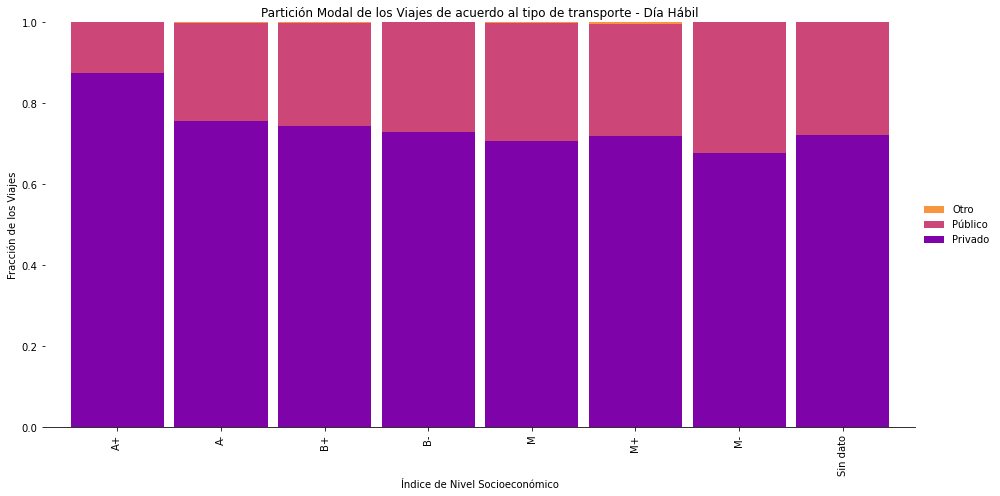

In [ ]:
from aves.visualization.tables import barchart

fig, ax = plt.subplots(figsize=(14, 7))

barchart(
    ax, df_norm, stacked=True, normalize=False, sort_categories=True, sort_items=False
)

ax.set_title("Partición Modal de los Viajes de acuerdo al tipo de transporte - Día Hábil")
ax.set_ylim([0, 1])
ax.set_ylabel("Fracción de los Viajes")
ax.set_xlabel("Índice de Nivel Socioeconómico")

fig.tight_layout()

La fracción de viajes privados y públicos es mayormente constante a través de los grupos, excepto en el nivel socioeconómico mayor, donde la fracción de viajes privado es más alta que el resto.

### Parte II: Indicadores de Tiempo de Viajes

En esta segunda parte, responderemos algunas preguntas respecto a indicadores de tiempo de viajes realizados, en días hábiles y no hábiles de viaje. Para esto, buscaremos responder las siguientes preguntas:
1. ¿Cuál es el tiempo promedio de viaje por modo y tipo de transporte?
2. ¿Cuál es el tiempo promedio de viaje en hora punta de mañana?
3. ¿Cuál es el tiempo de viaje en transporte público en hora punta de mañana?
4. ¿Cuál es el tiempo promedio de viaje al trabajo en transporte público?

En esta sección, se presentarán los indicadores de tiempo de viajes a nivel de viajes, durante días hábiles, y por clasificador socioeconómico.

#### **¿Cuál es el tiempo promedio de viaje por modo y tipo de transporte?**

A continuación, se representa el promedio y mediana en minutos de viaje por modo y tipo de transporte en días hábiles y no hábiles, por clasificador socioeconómico.

In [ ]:
print('Duración promedio (en minutos) de viaje por modo - Dia Hábil')
df = viajes_habiles.groupby(["INSE_RecF", 'modoprincipal']).apply(lambda x: weighted_mean(x, 'duracion', 'wcal0_x')).unstack()

Duración promedio (en minutos) de viaje por modo - Dia Hábil


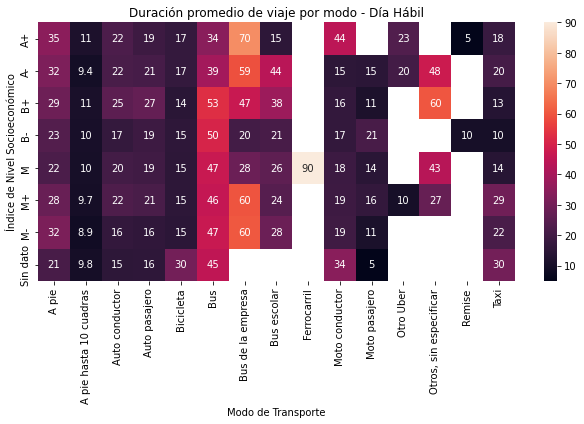

In [ ]:
fig, ax = plt.subplots(figsize=(9, 6))

ax = sns.heatmap(df, annot=True)

ax.set_title("Duración promedio de viaje por modo - Día Hábil")
ax.set_xlabel("Modo de Transporte")
ax.set_ylabel("Índice de Nivel Socioeconómico")

fig.tight_layout()

In [ ]:
print('Duración mediana (en minutos) de viaje por modo - Dia Hábil')
df = viajes_habiles.groupby(["INSE_RecF", 'modoprincipal']).apply(lambda x: weighted_median(x, 'duracion', 'wcal0_x')).unstack()

Duración mediana (en minutos) de viaje por modo - Dia Hábil


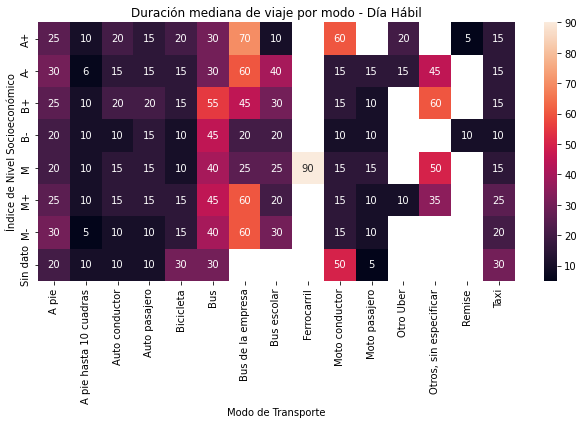

In [ ]:
fig, ax = plt.subplots(figsize=(9, 6))

ax = sns.heatmap(df, annot=True)

ax.set_title("Duración mediana de viaje por modo - Día Hábil")
ax.set_xlabel("Modo de Transporte")
ax.set_ylabel("Índice de Nivel Socioeconómico")

fig.tight_layout()

Los viajes con mayor duración promedio corresponden a los realizados en Bus y Bus de la Empresa, con variaciones a través de los grupos socioeconómicos. Los viajes más cortos son los realizados A pie hasta 10 cuadras, y como Moto pasajero.

In [ ]:
print('Duración promedio (en minutos) de viaje por tipo de transporte - Dia Hábil')
df = viajes_habiles.groupby(["INSE_RecF", 'publico_privado']).apply(lambda x: weighted_mean(x, 'duracion', 'wcal0_x')).unstack()

Duración promedio (en minutos) de viaje por tipo de transporte - Dia Hábil


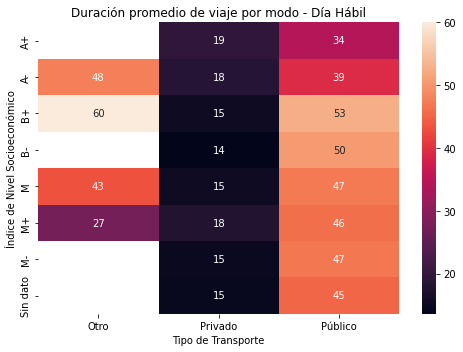

In [ ]:
fig, ax = plt.subplots(figsize=(7, 5))

ax = sns.heatmap(df, annot=True)

ax.set_title("Duración promedio de viaje por modo - Día Hábil")
ax.set_xlabel("Tipo de Transporte")
ax.set_ylabel("Índice de Nivel Socioeconómico")

fig.tight_layout()

In [ ]:
print('Duración mediana (en minutos) de viaje por tipo de transporte - Dia Hábil')
df = viajes_habiles.groupby(["INSE_RecF", 'publico_privado']).apply(lambda x: weighted_median(x, 'duracion', 'wcal0_x')).unstack()

Duración mediana (en minutos) de viaje por tipo de transporte - Dia Hábil


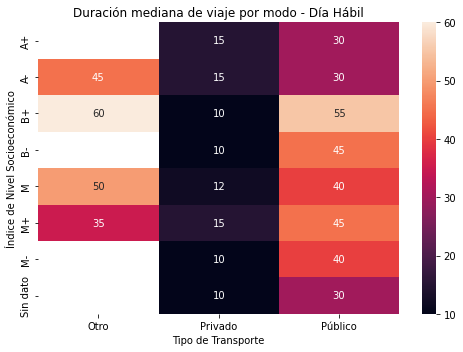

In [ ]:
fig, ax = plt.subplots(figsize=(7,5))

ax = sns.heatmap(df, annot=True)

ax.set_title("Duración mediana de viaje por modo - Día Hábil")
ax.set_xlabel("Tipo de Transporte")
ax.set_ylabel("Índice de Nivel Socioeconómico")

fig.tight_layout()

Se observa que los viajes realizados en transporte público son de mayor duración que los realizados en transporte privado, y además, los viajes en transporte público son más largos para las capas socioeconómicas medias y bajas.

#### **¿Cuál es el tiempo promedio de viaje en hora punta de mañana?**

Estos son los resultados para el promedio y mediana en minutos de viaje en hora punta de la mañana por modo de transporte, en días hábiles y no hábiles, por clasificador socioeconómico.

In [ ]:
print('Duración promedio (en minutos) de viaje por modo en hora punta - Dia Hábil')
df = viajes_habiles[viajes_habiles.PICO_HABIL=='Si'].groupby(["INSE_RecF", 'modoprincipal']).apply(lambda x: weighted_mean(x, 'duracion', 'wcal0_x')).unstack()

Duración promedio (en minutos) de viaje por modo en hora punta - Dia Hábil


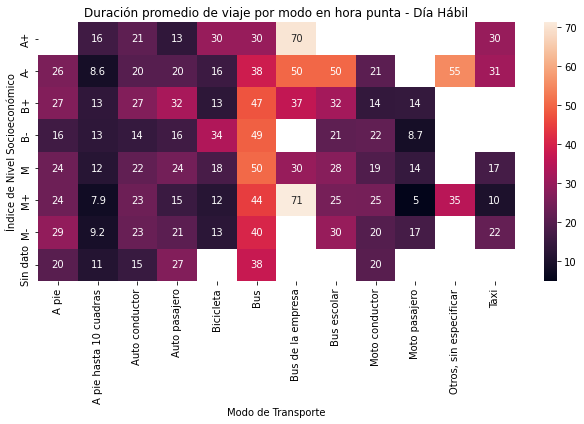

In [ ]:
fig, ax = plt.subplots(figsize=(9,6))

ax = sns.heatmap(df, annot=True)

ax.set_title("Duración promedio de viaje por modo en hora punta - Día Hábil")
ax.set_xlabel("Modo de Transporte")
ax.set_ylabel("Índice de Nivel Socioeconómico")

fig.tight_layout()

In [ ]:
print('Duración mediana (en minutos) de viaje por modo en hora punta - Dia Hábil')
df = viajes_habiles[viajes_habiles.PICO_HABIL=='Si'].groupby(["INSE_RecF", 'modoprincipal']).apply(lambda x: weighted_median(x, 'duracion', 'wcal0_x')).unstack()

Duración mediana (en minutos) de viaje por modo en hora punta - Dia Hábil


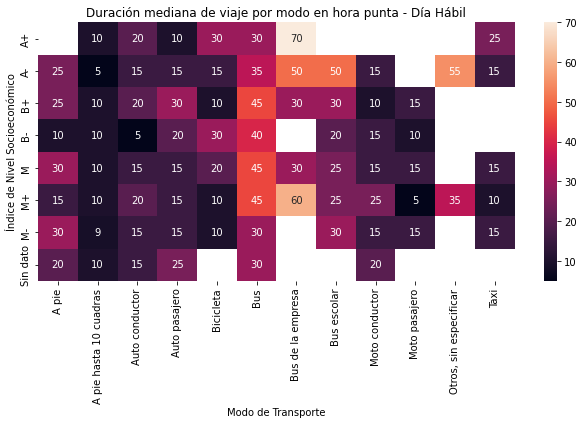

In [ ]:
fig, ax = plt.subplots(figsize=(9,6))

ax = sns.heatmap(df, annot=True)

ax.set_title("Duración mediana de viaje por modo en hora punta - Día Hábil")
ax.set_xlabel("Modo de Transporte")
ax.set_ylabel("Índice de Nivel Socioeconómico")

fig.tight_layout()

In [ ]:
print('Duración promedio (en minutos) de viaje por tipo de transporte en hora punta - Dia Hábil')
df = viajes_habiles[(viajes_habiles.PICO_HABIL=='Si')].groupby(["INSE_RecF", 'publico_privado']).apply(lambda x: weighted_mean(x, 'duracion', 'wcal0_x')).unstack()

Duración promedio (en minutos) de viaje por tipo de transporte en hora punta - Dia Hábil


Los viajes realizados en hora punta de mañana son de mayor duración para el modo de transporte Bus a lo largo de todos los grupos, y también alcanza valores altos en Bus de la empresa para algunos grupos. Los viajes más cortos corresponden a los realizados A pie hasta 10 cuadras.

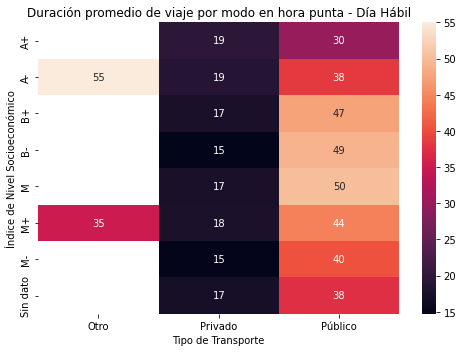

In [ ]:
fig, ax = plt.subplots(figsize=(7,5))

ax = sns.heatmap(df, annot=True)

ax.set_title("Duración promedio de viaje por modo en hora punta - Día Hábil")
ax.set_xlabel("Tipo de Transporte")
ax.set_ylabel("Índice de Nivel Socioeconómico")

fig.tight_layout()

In [ ]:
print('Duración mediana (en minutos) de viaje por tipo de transporte en hora punta - Dia Hábil')
df = viajes_habiles[(viajes_habiles.PICO_HABIL=='Si')].groupby(["INSE_RecF", 'publico_privado']).apply(lambda x: weighted_median(x, 'duracion', 'wcal0_x')).unstack()

Duración mediana (en minutos) de viaje por tipo de transporte en hora punta - Dia Hábil


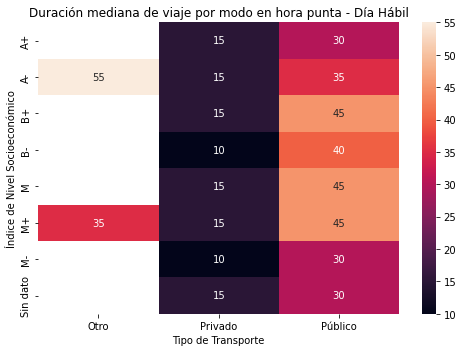

In [ ]:
fig, ax = plt.subplots(figsize=(7,5))

ax = sns.heatmap(df, annot=True)

ax.set_title("Duración mediana de viaje por modo en hora punta - Día Hábil")
ax.set_xlabel("Tipo de Transporte")
ax.set_ylabel("Índice de Nivel Socioeconómico")

fig.tight_layout()

Los viajes en hora punta de mañana son más largos cuando se realizan en transporte público que en privado, y aumentan sus duraciones para capas socioeconómicas medias y bajas.

#### **¿Cuál es el tiempo de viaje en transporte público en hora punta de mañana?**

A continuación, se presentan los resultados para duración promedio de viaje en hora punta de mañana en transporte público, en días hábiles y no hábiles, por clasificador socioeconómico.

In [ ]:
print('Duración promedio (en minutos) de viaje en hora punta en transporte público - Dia Hábil')
mask = (viajes_habiles.publico_privado=='Público')
df = viajes_habiles[mask][(viajes_habiles.PICO_HABIL=='Si')].groupby(["INSE_RecF", 'modoprincipal']).apply(lambda x: weighted_mean(x, 'duracion', 'wcal0_x')).unstack()

Duración promedio (en minutos) de viaje en hora punta en transporte público - Dia Hábil


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


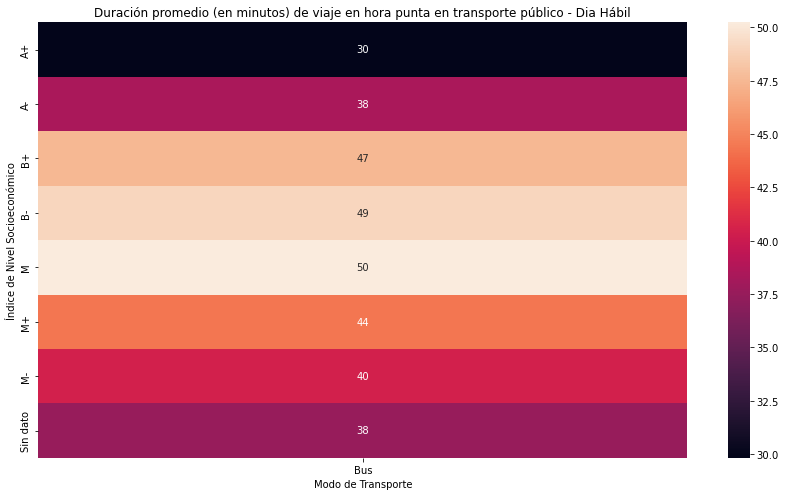

In [ ]:
fig, ax = plt.subplots(figsize=(12, 7))

ax = sns.heatmap(df, annot=True)

ax.set_title("Duración promedio (en minutos) de viaje en hora punta en transporte público - Dia Hábil")
ax.set_xlabel("Modo de Transporte")
ax.set_ylabel("Índice de Nivel Socioeconómico")

fig.tight_layout()

In [ ]:
print('Duración mediana (en minutos) de viaje en hora punta en transporte público - Dia Hábil')
mask = (viajes_habiles.publico_privado=='Público')
df = viajes_habiles[mask][(viajes_habiles.PICO_HABIL=='Si')].groupby(["INSE_RecF", 'modoprincipal']).apply(lambda x: weighted_median(x, 'duracion', 'wcal0_x')).unstack()

Duración mediana (en minutos) de viaje en hora punta en transporte público - Dia Hábil


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


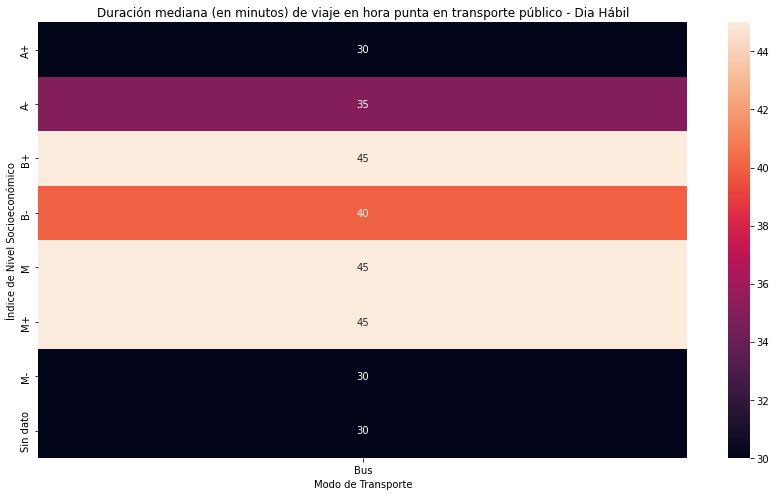

In [ ]:
fig, ax = plt.subplots(figsize=(12, 7))

ax = sns.heatmap(df, annot=True)

ax.set_title("Duración mediana (en minutos) de viaje en hora punta en transporte público - Dia Hábil")
ax.set_xlabel("Modo de Transporte")
ax.set_ylabel("Índice de Nivel Socioeconómico")

fig.tight_layout()

#### **¿Cuál es el tiempo promedio de viaje al trabajo en transporte público?**

A continuación, se presentan los resultados de tiempo promedio de viaje al trabajo en transporte público por modo en días hábiles y no hábiles, por clasificador socioeconómico.

In [ ]:
viajes_habiles.proposito.unique()

array(['Trabajo', 'Regreso al hogar/hogar', 'Compras (hogar)',
       'Asistencia médica', 'Otro', 'Entretenimiento / ocio',
       'Visitar a alguien', 'Estudios', 'Ir a comer', 'Tramites personal',
       'Dejar/recoger niños', 'Tramites trabajo', 'Acompañar a alguien',
       'Compras', 'Dejar/recoger a alguien', 'Culto', 'Sin_dato'],
      dtype=object)

In [ ]:
work = ['Trabajo','Tramites trabajo']

In [ ]:
print('Duración promedio (en minutos) de viaje al trabajo en transporte público - Dia Hábil')
mask = (viajes_habiles.publico_privado=='Público') & (viajes_habiles.proposito.isin(work))
df = viajes_habiles[mask].groupby(["INSE_RecF", "modoprincipal"]).apply(lambda x: weighted_mean(x, 'duracion', 'wcal0_x')).unstack()

Duración promedio (en minutos) de viaje al trabajo en transporte público - Dia Hábil


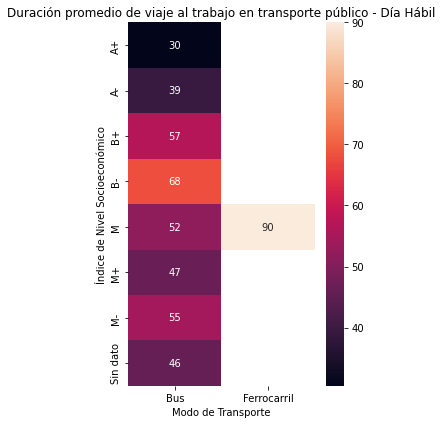

In [ ]:
fig, ax = plt.subplots(figsize=(4, 6))

ax = sns.heatmap(df, annot=True)

ax.set_title("Duración promedio de viaje al trabajo en transporte público - Día Hábil")
ax.set_xlabel("Modo de Transporte")
ax.set_ylabel("Índice de Nivel Socioeconómico")

fig.tight_layout()

In [ ]:
print('Duración mediana (en minutos) de viaje al trabajo en transporte público - Dia Hábil')
mask = (viajes_habiles.publico_privado=='Público') & (viajes_habiles.proposito.isin(work))
df = viajes_habiles[mask].groupby(["INSE_RecF", "modoprincipal"]).apply(lambda x: weighted_median(x, 'duracion', 'wcal0_x')).unstack()

Duración mediana (en minutos) de viaje al trabajo en transporte público - Dia Hábil


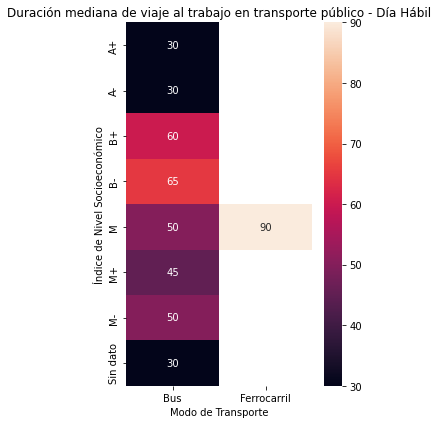

In [ ]:
fig, ax = plt.subplots(figsize=(4, 6))

ax = sns.heatmap(df, annot=True)

ax.set_title("Duración mediana de viaje al trabajo en transporte público - Día Hábil")
ax.set_xlabel("Modo de Transporte")
ax.set_ylabel("Índice de Nivel Socioeconómico")

fig.tight_layout()

### Parte III: Indicadores de Distancia de Viajes
1. Distancia de viajes en auto (histograma de viajes por km)
2.Distancia de viajes en transporte público (histograma de viajes por km)
3.Distancia de viajes por motivo estudio (histograma de viajes por km)
4.Distancia de viajes por motivo al trabajo (histograma de viajes por km)
5.Viajes interzonales como intrazonales


En esta sección, se presentarán los indicadores de distancia de viajes durante días hábiles.

In [ ]:
car = ['Auto conductor','Auto pasajero']

Distancia de viajes en auto - Día Hábil


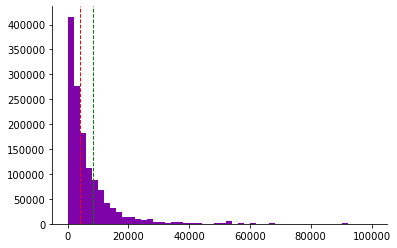

In [ ]:
from matplotlib.pyplot import hist
print('Distancia de viajes en auto - Día Hábil')
mask = (viajes_habiles.modoprincipal.isin(car))
df = viajes_habiles[mask].groupby('distancia_manhattan').sum()[['wcal0_x']].reset_index().sort_values('distancia_manhattan')
hist(df.distancia_manhattan, weights=df.wcal0_x, bins=50)
plt.axvline(viajes_habiles[mask].groupby('idviaje').apply(lambda x: weighted_mean(x, 'distancia_manhattan', 'wcal0_x')).mean(), color='green', linestyle='dashed', linewidth=1)
plt.axvline(viajes_habiles[mask].groupby('idviaje').apply(lambda x: weighted_median(x, 'distancia_manhattan', 'wcal0_x')).median(), color='red', linestyle='dashed', linewidth=1)
sns.despine()
#Verde Promedio
#Rojo Mediana

#### **Distancia de viajes en transporte público**

Distancia de viajes en transporte público - Día Hábil


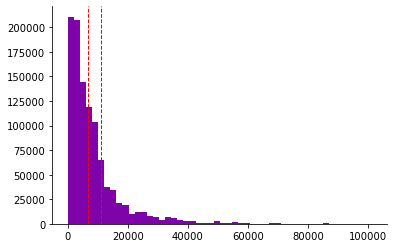

In [ ]:
print('Distancia de viajes en transporte público - Día Hábil')
mask = (viajes_habiles.publico_privado == 'Público')
df = viajes_habiles[mask].groupby('distancia_manhattan').sum()[['wcal0_x']].reset_index().sort_values('distancia_manhattan')
hist(df.distancia_manhattan, weights=df.wcal0_x, bins=50)
plt.axvline(viajes_habiles[mask].groupby('idviaje').apply(lambda x: weighted_mean(x, 'distancia_manhattan', 'wcal0_x')).mean(), color='green', linestyle='dashed', linewidth=1)
plt.axvline(viajes_habiles[mask].groupby('idviaje').apply(lambda x: weighted_median(x, 'distancia_manhattan', 'wcal0_x')).median(), color='red', linestyle='dashed', linewidth=1)
sns.despine()
#Verde Promedio
#Rojo Mediana

In [ ]:
viajes_habiles.proposito.unique()

array(['Trabajo', 'Regreso al hogar/hogar', 'Compras (hogar)',
       'Asistencia médica', 'Otro', 'Entretenimiento / ocio',
       'Visitar a alguien', 'Estudios', 'Ir a comer', 'Tramites personal',
       'Dejar/recoger niños', 'Tramites trabajo', 'Acompañar a alguien',
       'Compras', 'Dejar/recoger a alguien', 'Culto', 'Sin_dato'],
      dtype=object)

#### **Distancia de viajes por motivo estudio**

Distancia de viajes con motivo de estudio


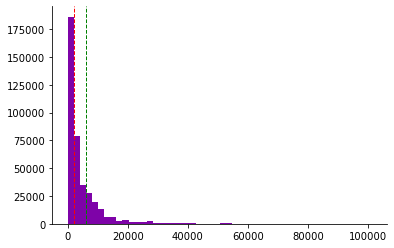

In [ ]:
print('Distancia de viajes con motivo de estudio')
mask = (viajes_personas.proposito == 'Estudios')
df = viajes_personas[mask].groupby('distancia_manhattan').sum()[['wcal0_x']].reset_index().sort_values('distancia_manhattan')
hist(df.distancia_manhattan, weights=df.wcal0_x, bins=50)
plt.axvline(viajes_habiles[mask].groupby('idviaje').apply(lambda x: weighted_mean(x, 'distancia_manhattan', 'wcal0_x')).mean(), color='green', linestyle='dashed', linewidth=1)
plt.axvline(viajes_habiles[mask].groupby('idviaje').apply(lambda x: weighted_median(x, 'distancia_manhattan', 'wcal0_x')).median(), color='red', linestyle='dashed', linewidth=1)
sns.despine()
#Verde Promedio
#Rojo Mediana

#### **Distancia de viajes por motivo trabajo**

Distancia de viajes con motivo de trabajo


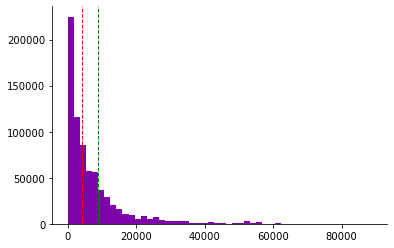

In [ ]:
print('Distancia de viajes con motivo de trabajo')
mask = (viajes_personas.proposito.isin(work))
df = viajes_personas[mask].groupby('distancia_manhattan').sum()[['wcal0_x']].reset_index().sort_values('distancia_manhattan')
hist(df.distancia_manhattan, weights=df.wcal0_x, bins=50)
plt.axvline(viajes_habiles[mask].groupby('idviaje').apply(lambda x: weighted_mean(x, 'distancia_manhattan', 'wcal0_x')).mean(), color='green', linestyle='dashed', linewidth=1)
plt.axvline(viajes_habiles[mask].groupby('idviaje').apply(lambda x: weighted_median(x, 'distancia_manhattan', 'wcal0_x')).median(), color='red', linestyle='dashed', linewidth=1)
sns.despine()
#Verde Promedio
#Rojo Mediana

#### **Viajes intra vs interzonales**

In [ ]:
print('% de viajes Inter e Intra zonales')
df = viajes_personas.groupby(['proposito','SEXO','Intra_Inter']).sum()['wcal0_x'].unstack()
df.div(df.sum(axis=1), axis=0)

% de viajes Inter e Intra zonales


Intra_Inter                           Inter     Intra
proposito               SEXO                         
Acompañar a alguien     Femenino   0.893218  0.106782
                        Masculino  0.923614  0.076386
Asistencia médica       Femenino   0.991291  0.008709
                        Masculino  0.985074  0.014926
Compras                 Femenino   0.822042  0.177958
                        Masculino  0.896874  0.103126
Compras (hogar)         Femenino   0.686774  0.313226
                        Masculino  0.722449  0.277551
Culto                   Femenino   0.871803  0.128197
                        Masculino  0.891276  0.108724
Dejar/recoger a alguien Femenino   0.947872  0.052128
                        Masculino  0.956817  0.043183
Dejar/recoger niños     Femenino   0.807324  0.192676
                        Masculino  0.926885  0.073115
Entretenimiento / ocio  Femenino   0.913159  0.086841
                        Masculino  0.945747  0.054253
Estudios                Femenino   0.913157  0.086843
                        Masculino  0.892821  0.107179
Ir a comer              Femenino   0.794449  0.205551
                        Masculino  0.817926  0.182074
Otro                    Femenino   0.878522  0.121478
                        Masculino  0.933994  0.066006
Regreso al hogar/hogar  Femenino   0.875024  0.124976
                        Masculino  0.902766  0.097234
Sin_dato                Masculino  1.000000       NaN
Trabajo                 Femenino   0.956647  0.043353
                        Masculino  0.958317  0.041683
Tramites personal       Femenino   0.951074  0.048926
                        Masculino  0.996238  0.003762
Tramites trabajo        Femenino   0.979943  0.020057
                        Masculino  0.962105  0.037895
Visitar a alguien       Femenino   0.875741  0.124259
                        Masculino  0.869526  0.130474

¿Dónde se concentran las personas que utilizan cada modo de transporte en la ciudad para distintos propósitos?

<AxesSubplot:>

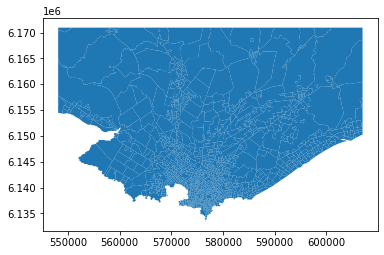

In [ ]:
from aves.features.geo import clip_area_geodataframe
bbox = [548103.7465,6130534.7073,607001.8892,6170942.9774]

zonas_en_caja = clip_area_geodataframe(city_shp.to_crs('epsg:32721'), bbox)
zonas_en_caja.plot()

In [ ]:
bounds = zonas_en_caja.to_crs('EPSG:4686').total_bounds

In [ ]:
import contextily as cx

scl_img, scl_ext = cx.bounds2raster(bounds[0], bounds[1], bounds[2], bounds[3], 
    "montevideo_toner_12.tif",
    ll=True,
    source=cx.providers.Stamen.TonerBackground,
    zoom=12,
)

In [ ]:
from aves.features.geo import to_point_geodataframe

In [ ]:
origenes_viajes = to_point_geodataframe(viajes_personas, 'LONGITUD_ORIGEN' , 'LATITUD_ORIGEN', crs='epsg:32721')
destinos_viajes = to_point_geodataframe(viajes_personas, 'LONGITUD_DESTINO', 'LATITUD_DESTINO', crs='epsg:32721')

In [ ]:
city_shp = city_shp.to_crs(origenes_viajes.crs)

In [ ]:
from aves.features.geo import clip_point_geodataframe

origenes_viajes = origenes_viajes[(origenes_viajes['idviaje'].isin(destinos_viajes['idviaje']))]
origenes_viajes = clip_point_geodataframe(origenes_viajes, zonas_en_caja.total_bounds)
destinos_viajes = destinos_viajes[(destinos_viajes['idviaje'].isin(origenes_viajes['idviaje']))]
destinos_viajes = clip_point_geodataframe(destinos_viajes, zonas_en_caja.total_bounds)

In [ ]:
origenes_viajes.columns

Index(['nform', 'nnper', 'nvj', 'IDPERV', 'origen', 'proposito', 'VF5', 'VF6',
       'tiempoviaje', 'modoprincipal', 'codsegorigen', 'codsegproposito',
       'wcal0_x', 'LATITUD_ORIGEN', 'LONGITUD_ORIGEN', 'LATITUD_DESTINO',
       'LONGITUD_DESTINO', 'PICO_HABIL', 'Intra_Inter', 'publico_privado',
       'motorizado', 'duracion', 'distancia_manhattan', 'idviaje', 'IDPER',
       'SEXO', 'INSE', 'INSE_RecF', 'wcal0_y', 'E10', 'EDAD', 'codseghogar',
       'CODSEG', 'CODLOC', 'NOMBLOC', 'geometry'],
      dtype='object')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:36: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


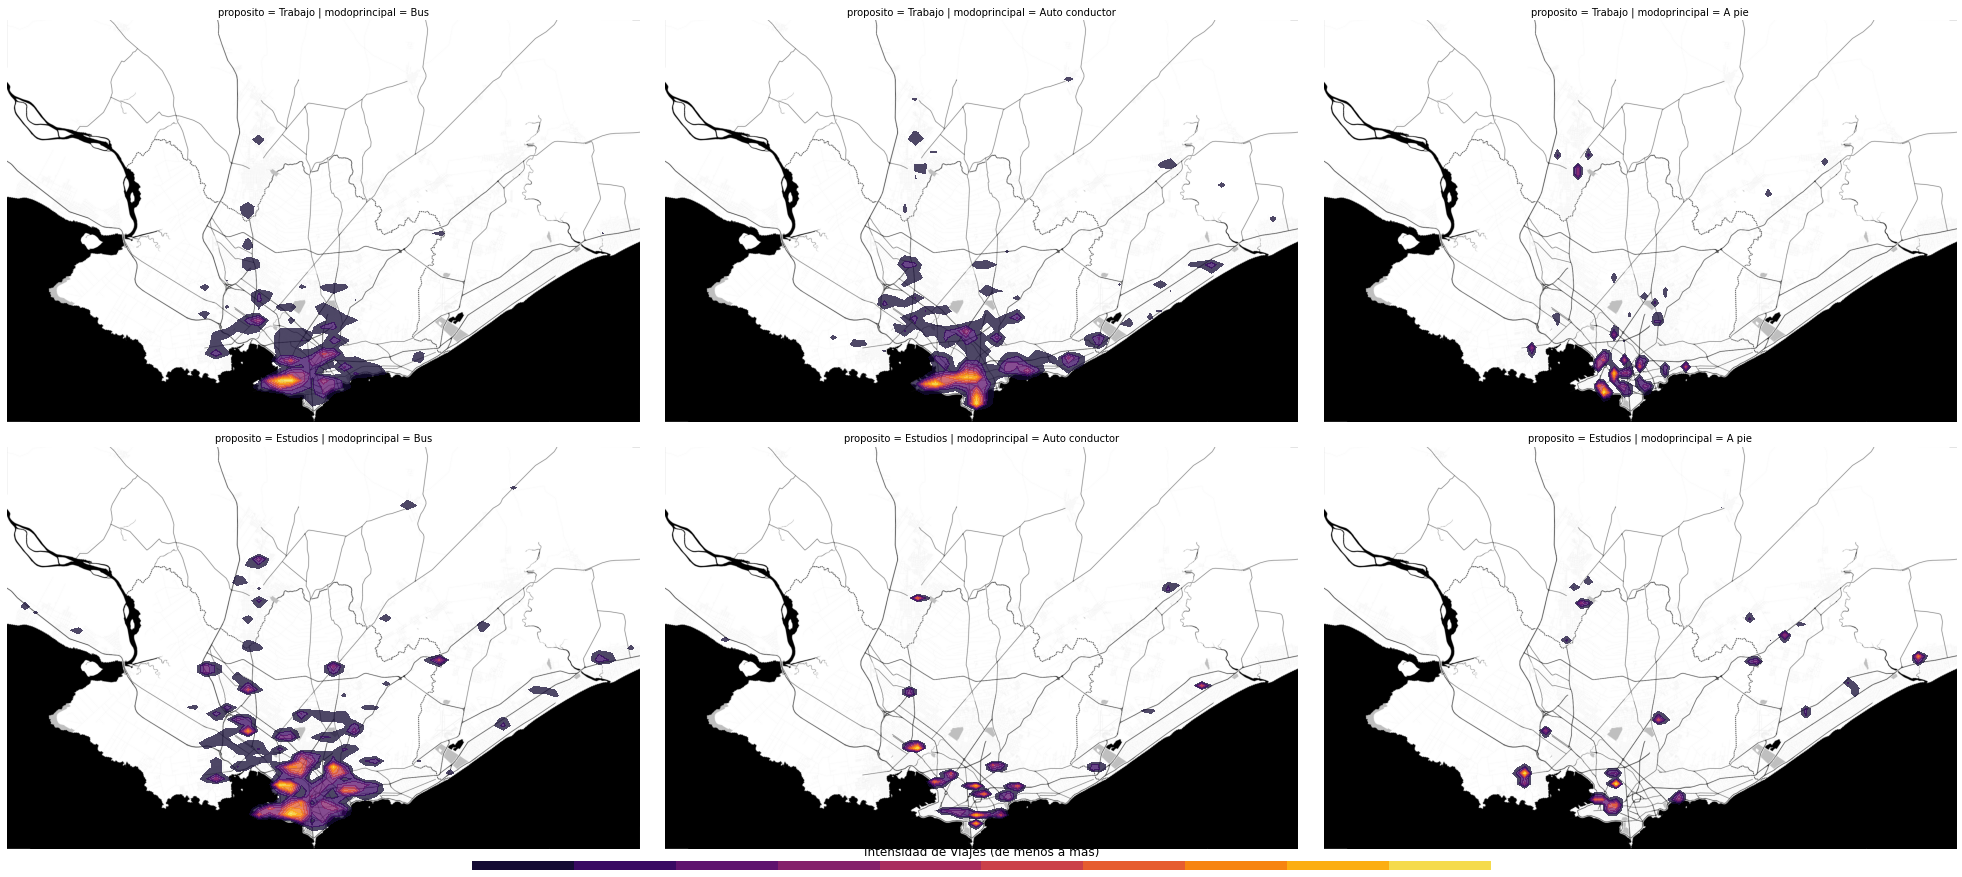

In [ ]:
from aves.visualization.figures import GeoFacetGrid

from aves.visualization.maps import heat_map

grid = GeoFacetGrid(
    origenes_viajes,
    context=zonas_en_caja,
    row="proposito",
    col="modoprincipal",
    row_order=["Trabajo", "Estudios"],
    col_order=["Bus", "Auto conductor", "A pie"],
    height=6,
    hue="modoprincipal"
)
grid.add_basemap("montevideo_toner_12.tif")
#grid.add_layer(city_shp_filt, color="#efefef", edgecolor="white", linewidth=1)

grid.add_layer(
    heat_map,
    # atributo de los datos con la importancia o peso de cada viaje
    weight="wcal0_x",
    # cantidad de niveles/colores del mapa de calor
    n_levels=10,
    # radio de influencia de cada viaje
    bandwidth=0.005,
    # valor de corte para los valores bajos del heatmap
    low_threshold=0.075,
    # transparencia
    alpha=0.75,
    # paleta de colores
    palette="inferno"
)

grid.add_global_colorbar('inferno', 10, title='Intensidad de Viajes (de menos a más)', orientation='horizontal')
#grid.set_title("Viajes a trabajar y a estudiar de acuerdo al modo de transporte")
grid.fig.tight_layout()

In [ ]:
destinos_viajes.proposito.unique()

array(['Trabajo', 'Regreso al hogar/hogar', 'Compras (hogar)',
       'Asistencia médica', 'Otro', 'Entretenimiento / ocio',
       'Visitar a alguien', 'Estudios', 'Ir a comer', 'Tramites personal',
       'Dejar/recoger niños', 'Tramites trabajo', 'Acompañar a alguien',
       'Compras', 'Dejar/recoger a alguien', 'Culto', 'Sin_dato'],
      dtype=object)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


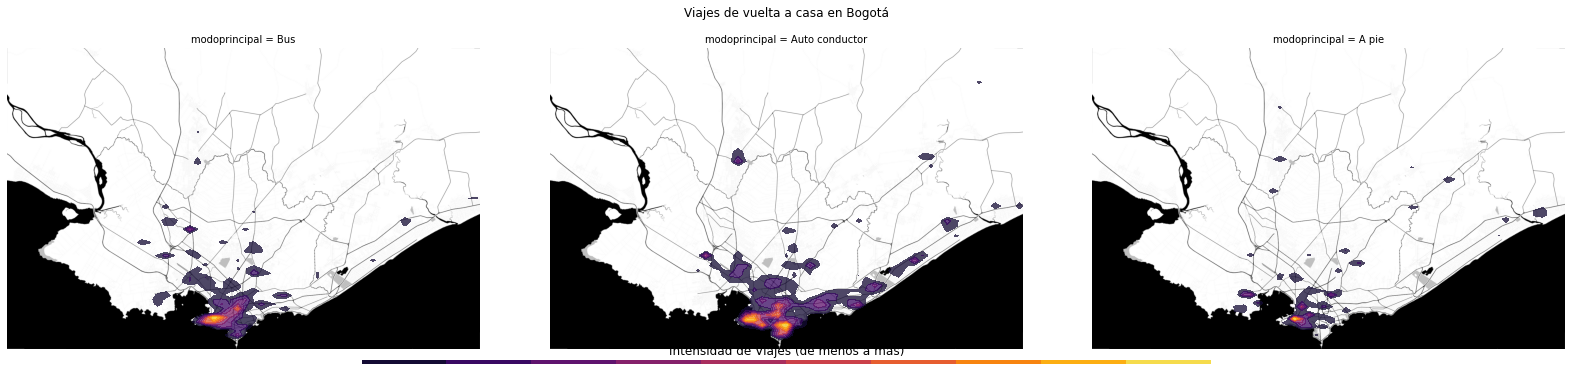

In [ ]:
grid = GeoFacetGrid(
    destinos_viajes[destinos_viajes.proposito=='Regreso al hogar/hogar'],
    context=zonas_en_caja,
    #row="MOTIVOVIAJE",
    col="modoprincipal",
    col_wrap=3,
    row_order=["Regreso al hogar/hogar"],
    col_order=["Bus", "Auto conductor", "A pie"],
    height=5,
    hue="modoprincipal"
)
grid.add_basemap("montevideo_toner_12.tif")
#grid.add_layer(city_shp_filt, color="#efefef", edgecolor="white", linewidth=1, alpha=0.5)

grid.add_layer(
    heat_map,
    # atributo de los datos con la importancia o peso de cada viaje
    weight="wcal0_x",
    # cantidad de niveles/colores del mapa de calor
    n_levels=10,
    # radio de influencia de cada viaje
    bandwidth=0.005,
    # valor de corte para los valores bajos del heatmap
    low_threshold=0.075,
    # transparencia
    alpha=0.75,
    # paleta de colores
    palette="inferno"
)
grid.add_global_colorbar('inferno', 10, title='Intensidad de Viajes (de menos a más)', orientation='horizontal')
grid.set_title("Viajes de vuelta a casa en Bogotá")
grid.fig.tight_layout()

¿Cuán lejos queda el trabajo de acuerdo al lugar de residencia?

Con esta pregunta queremos entender si existe un patrón geográfico en las elecciones de residencia y trabajo de las personas.

Para responder la pregunta, primero filtramos los viajes que nos interesan:

In [ ]:
viajes_trabajo = origenes_viajes[(origenes_viajes.proposito == 'Trabajo') &
                                (pd.notnull(origenes_viajes.wcal0_x)) &
                                (origenes_viajes.distancia_manhattan > 0)].drop_duplicates(subset=['nform', 'nnper'], keep='first')
                                
print(len(viajes_trabajo), viajes_trabajo.wcal0_x.sum())

1378 509451.64144529


In [ ]:
viajes_trabajo['distancia_manhattan'].mean(), weighted_mean(viajes_trabajo, 'distancia_manhattan', 'wcal0_x')

(10186.546252620412, 7656.501474833837)

In [ ]:
viajes_trabajo.columns

Index(['nform', 'nnper', 'nvj', 'IDPERV', 'origen', 'proposito', 'VF5', 'VF6',
       'tiempoviaje', 'modoprincipal', 'codsegorigen', 'codsegproposito',
       'wcal0_x', 'LATITUD_ORIGEN', 'LONGITUD_ORIGEN', 'LATITUD_DESTINO',
       'LONGITUD_DESTINO', 'PICO_HABIL', 'Intra_Inter', 'publico_privado',
       'motorizado', 'duracion', 'distancia_manhattan', 'idviaje', 'IDPER',
       'SEXO', 'INSE', 'INSE_RecF', 'wcal0_y', 'E10', 'EDAD', 'codseghogar',
       'CODSEG', 'CODLOC', 'NOMBLOC', 'geometry'],
      dtype='object')

In [ ]:
distancia_zonas_mean = (viajes_trabajo
                   .groupby(['codsegorigen'])
                   .apply(lambda x: weighted_mean(x, 'distancia_manhattan', 'wcal0_x'))
                   .rename('media_distancia_al_trabajo')
)

In [ ]:
distancia_zonas_median = (viajes_trabajo
                   .groupby(['codsegorigen'])
                   .apply(lambda x: weighted_median(x, 'distancia_manhattan', 'wcal0_x'))
                   .rename('mediana_distancia_al_trabajo')
)

/usr/local/lib/python3.7/site-packages/seaborn/axisgrid.py:88: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)


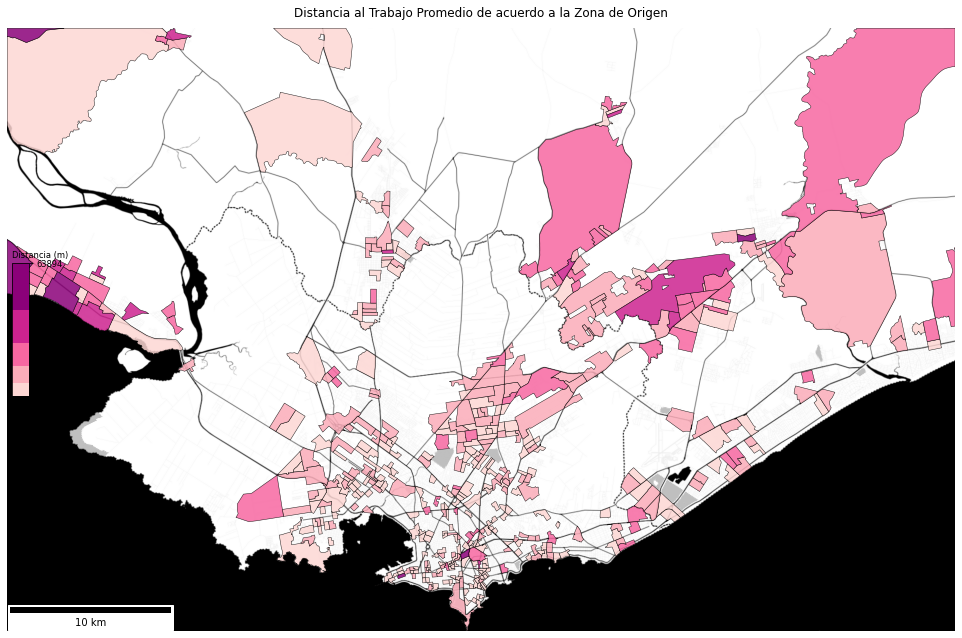

In [ ]:
from aves.visualization.maps import choropleth_map
grid = GeoFacetGrid(zonas_en_caja.set_index('CODSEG').join(distancia_zonas_mean, how="left"), height=9)
grid.add_basemap("montevideo_toner_12.tif")
grid.add_layer(
    choropleth_map,
    "media_distancia_al_trabajo",
    k=5,
    linewidth=0.5,
    edgecolor="black",
    binning="fisher_jenks",
    palette="RdPu",
    alpha=0.85,
    cbar_args=dict(
        label="Distancia (m)",
        height="22%",
        width="2%",
        orientation="vertical",
        location="center left",
        label_size="small",
        bbox_to_anchor=(0.0, 0.0, 0.9, 1.0),
    ),
)
grid.add_map_elements()
grid.set_title("Distancia al Trabajo Promedio de acuerdo a la Zona de Origen")
grid.tight_layout()

In [ ]:
matriz_zonas = (viajes_trabajo[(viajes_trabajo['codsegorigen'] != viajes_trabajo['codsegproposito'])
                            
                             & (viajes_trabajo['codsegorigen'].isin(zonas_en_caja.CODSEG))
                             & (viajes_trabajo['codsegproposito'].isin(zonas_en_caja.CODSEG))]
                    .groupby(['codsegorigen', 'codsegproposito'])
                    .agg(n_viajes=('wcal0_x', 'sum'))
                    .sort_values('n_viajes', ascending=False)
                    .assign(cumsum_viajes=lambda x: x['n_viajes'].cumsum())
                    .assign(cumsum_viajes=lambda x: x['cumsum_viajes'] / x['cumsum_viajes'].max())
                    .reset_index()
)

In [ ]:
matriz_zonas = matriz_zonas[matriz_zonas['cumsum_viajes'] <= 0.8]

In [ ]:
merged_zones = zonas_en_caja.dissolve('CODSEG')#.drop('id', axis=1)

In [ ]:
from aves.models.network import Network
from aves.visualization.networks import NodeLink

zone_od_network = Network.from_edgelist(
    matriz_zonas, source="codsegorigen", target="codsegproposito", weight="n_viajes"
)

In [ ]:
zone_nodelink = NodeLink(zone_od_network)

In [ ]:
zone_nodelink.layout_nodes(method="geographical", geodataframe=merged_zones)

In [ ]:
zone_nodelink.set_node_drawing("plain", weights=zone_od_network.node_degree("in"))
zone_nodelink.set_edge_drawing(method="origin-destination")

In [ ]:
zone_nodelink.bundle_edges(
    method="force-directed", K=10, S=0.01, I=10, compatibility_threshold=0.45, C=6
)

In [ ]:
def plot_network(ax, geo_data, *args, **kwargs):
    zone_nodelink.plot(ax, *args, **kwargs)

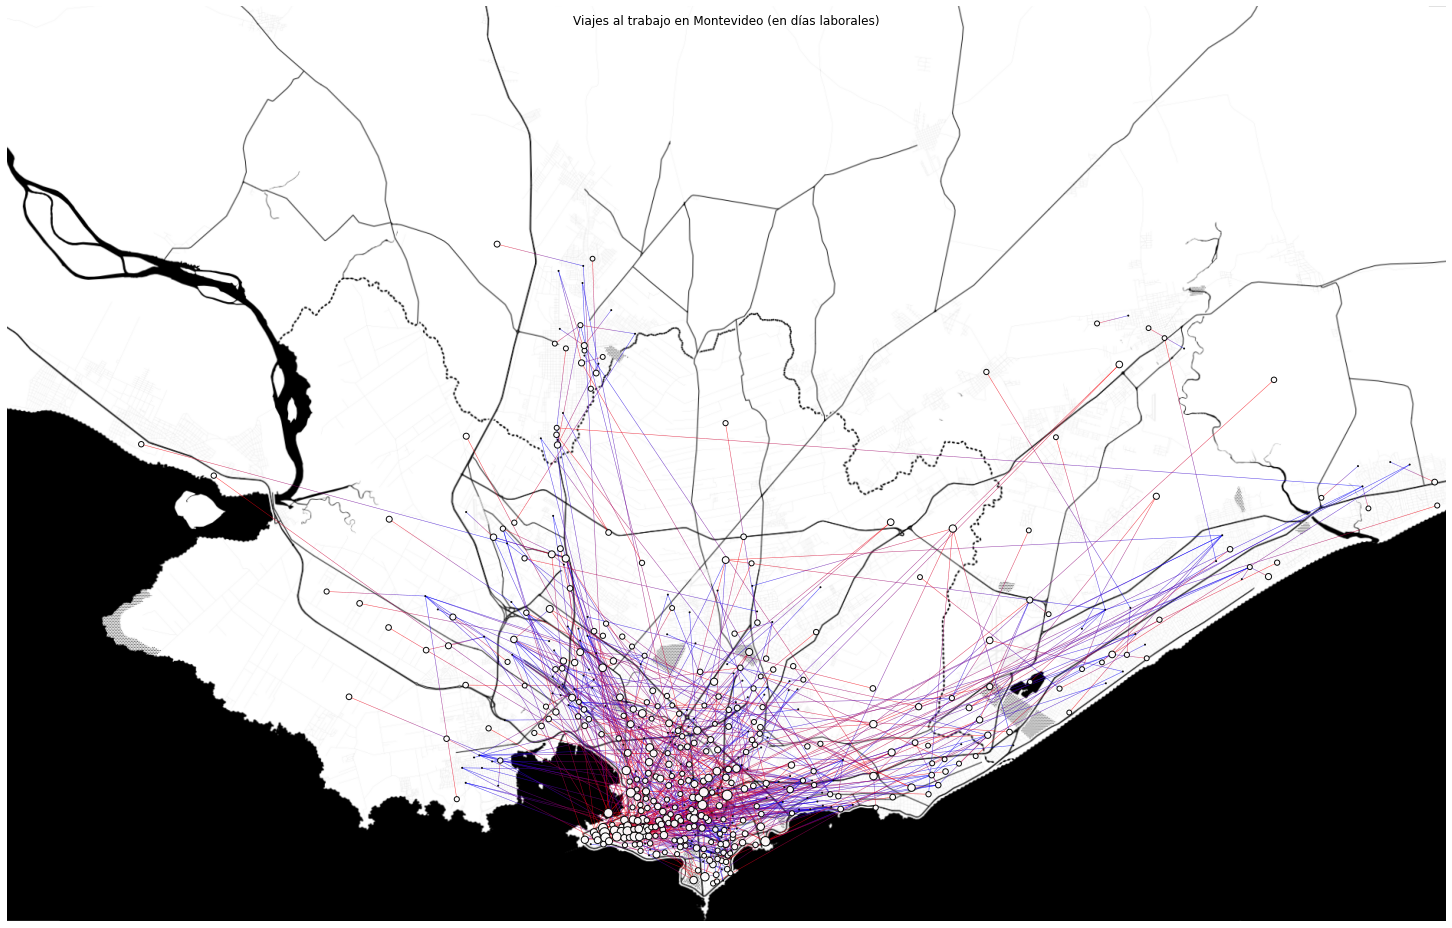

In [ ]:
grid = GeoFacetGrid(zonas_en_caja, height=13)
grid.add_basemap("montevideo_toner_12.tif")
#grid.add_layer(city_shp_filt,facecolor='white', edgecolor='grey', alpha=0.25)
grid.add_layer(
    plot_network,
    nodes=dict(color="white", edgecolor="black", node_size=100, alpha=0.95),
    edges=dict(linewidth=0.5, alpha=0.75),
)
grid.set_title("Viajes al trabajo en Montevideo (en días laborales)")